In [7]:
import warnings
import pandas as pd
import numpy as np
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.preprocessing import MinMaxScaler
import rpy2.robjects as robj
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import pickle
import json
import os
import pymc3 as pm
from functools import reduce
# The object that represents the R session
r = robj.r

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.


# Structure export

In [21]:
# SELECT IDF NUMBER AND NETWORK (STATIC MEANS ONLY PRIOR, UNROLLED OTHERWISE)
static=True
fan = 'CV1'


if fan == 'CV1':
    alpha = 6
    n_cycles = 685
else:
    alpha = 4
    n_cycles = 1400

#### Orphaned nodes (all Mkv orders)

In [ ]:
files = sorted([x[2] for x in os.walk(f'./nets/CV1/')][0])
files = [x for x in files if x.startswith(tuple([f'size{size}' for size in range(2, 10)]))]

for file in files:
  r(f'load(file="./nets/CV1/{file}")')
  flat_list = np.array(r['net'][2])
  ady_list = [[flat_list[i], flat_list[i+len(flat_list)//2]] for i in range(len(flat_list)//2) ]
  G_aux = nx.DiGraph()
  G_aux.add_edges_from(ady_list)
  print(sorted([x for x in set(x for x in np.array(r.names(r['net'][1]))) if x not in [y for y in G_aux.nodes]]))

In [23]:
r(f'''
  library(dbnR)
  load(file="./nets/{fan}/size6_dmmhc_mmpc_hc_mi-g_bic-g_5e-0{alpha}.RDS")
  ''')

In [24]:
with (robj.default_converter + pandas2ri.converter).context():
    nodes = np.array(robj.conversion.get_conversion().rpy2py(r("nodes(net)")))
    arcs = np.array(robj.conversion.get_conversion().rpy2py(r("arcs(net)")))
arcs = arcs.reshape(2, -1).T

nodes.sort()
nodes_static = [node for node in nodes if node[-1]=='5']
arcs_static = [[u,v] for u,v in arcs if u in nodes_static and v in nodes_static]
enc_nodes = {y:x for (x, y) in enumerate(nodes)}
enc_nodes_static = {y:x for (x, y) in enumerate(nodes_static)}


In [25]:
for node in nodes:
    if np.isin(arcs, node).sum() == 0:
        arcs = np.vstack([arcs, [node, None]])
enc_arcs = [(enc_nodes.get(u, None), enc_nodes.get(v, None)) for (u, v) in arcs]

for node in nodes_static:
    if np.isin(arcs_static, node).sum() == 0:
        arcs_static = np.vstack([arcs_static, [node, None]])
enc_arcs_static = [(enc_nodes_static.get(u, None), enc_nodes_static.get(v, None)) for (u, v) in arcs_static]

### NeuroSuites

In [26]:
neurosuites_df = pd.DataFrame(arcs, columns=['source', 'destination'])
neurosuites_df.to_csv(f'./nets/{fan}/exported/DGBN_ady_list.csv', index=False)

neurosuites_df = pd.DataFrame(arcs_static, columns=['source', 'destination'])
neurosuites_df.to_csv(f'./nets/{fan}/exported/DGBN_ady_list_static.csv', index=False)

In [27]:
def convert(adj, n_nodes):

	# Initialize a matrix
	matrix = [[0 for j in range(n_nodes)] 
				for i in range(n_nodes)]
	
	for (i, j) in adj:
		if i is not None and j is not None:
			matrix[i][j] = 1
	
	return matrix

In [28]:
# Full DBN
if not static:
    adjMatrix = convert(enc_arcs, len(nodes))
    neurosuites_df = pd.DataFrame(adjMatrix, columns=enc_nodes.keys())
    neurosuites_df = pd.concat([pd.DataFrame(np.array(list(enc_nodes.values())).reshape(-1, 1), columns=['id']), neurosuites_df], axis=1)
    neurosuites_df.to_csv(f'./nets/{fan}/exported/DGBN_ady_matrix.csv', index=False)

In [29]:
# Static slice
if static:
    adjMatrix = convert(enc_arcs_static, len(nodes_static))
    neurosuites_df = pd.DataFrame(adjMatrix, columns=enc_nodes_static.keys())
    neurosuites_df = pd.concat([pd.DataFrame(np.array(list(enc_nodes_static.values())).reshape(-1, 1), columns=['id']), neurosuites_df], axis=1)
    neurosuites_df.to_csv(f'./nets/{fan}/exported/DGBN_ady_matrix_static.csv', index=False)

In [30]:
process = ['XXXXXXXXXXX']
motors = ['XXXXXXXXXXX']
mechanical = ['XXXXXXXXXXX']

In [31]:
translation_dict = {
    'XXXXXXXXXXX' 
}
reversed_dict = dict(map(reversed,[(k,v) for k,v in translation_dict.items() if k[:3] == fan]))

In [32]:
# Full DBN
if not static:
    labels_multi_group = ['All groups', 'Motors and Mechanical', 'Motors only', 'Mechanical only', 'Process']
    labels_single_group = ['Motors', 'Mechanical', 'Process']
    groups = dict()
    groups['discrete_features'] = dict()
    groups['discrete_features']['multi_group'] = dict()
    for label, color in zip(labels_multi_group, ['#db0000', '#076c07', '#dbb500', '#70ca70', '#06918a']):
        groups['discrete_features']['multi_group'][label] = {'color':color}

    groups['discrete_features']['single_group'] = dict()
    for label, color in zip(labels_single_group, ['#db0000', '#076c07', '#dbb500']):
        groups['discrete_features']['single_group'][label] = {'color':color}
    groups['nodes'] = dict()
    for node in nodes:
        groups['nodes'][node] = dict()
        groups['nodes'][node]['discrete_features'] = dict()
        translated_node = reversed_dict[node[:-4]]
        if translated_node in [f'{fan}.' + x for x in process] and translated_node in [f'{fan}.' + x for x in motors] and translated_node in [f'{fan}.' + x for x in mechanical]:
            groups['nodes'][node]['discrete_features']['multi_group'] = [labels_multi_group[0]]
        elif translated_node in [f'{fan}.' + x for x in motors] and translated_node in [f'{fan}.' + x for x in mechanical]:
            groups['nodes'][node]['discrete_features']['multi_group'] = [labels_multi_group[1]]
        elif translated_node in [f'{fan}.' + x for x in motors]:
            groups['nodes'][node]['discrete_features']['multi_group'] = [labels_multi_group[2]]
        elif translated_node in [f'{fan}.' + x for x in mechanical]:
            groups['nodes'][node]['discrete_features']['multi_group'] = [labels_multi_group[3]]
        else:
            groups['nodes'][node]['discrete_features']['multi_group'] = [labels_multi_group[4]]

        groups['nodes'][node]['discrete_features']['single_group'] = []
        if translated_node in [f'{fan}.' + x for x in motors]:
            groups['nodes'][node]['discrete_features']['single_group'].append(labels_single_group[0])
        if translated_node in [f'{fan}.' + x for x in mechanical]:
            groups['nodes'][node]['discrete_features']['single_group'].append(labels_single_group[1])
        if translated_node in [f'{fan}.' + x for x in process]:
            groups['nodes'][node]['discrete_features']['single_group'].append(labels_single_group[2])
    with open(f'./nets/{fan}/exported/DGBN_groups.json', 'w') as f:
        f.write(json.dumps(groups, indent = 1, ensure_ascii=False))
        


In [33]:
# Static slice
if static:
    labels_multi_group = ['All groups', 'Motors and Mechanical', 'Motors only', 'Mechanical only', 'Process']
    labels_single_group = ['Motors', 'Mechanical', 'Process']
    groups = dict()
    groups['discrete_features'] = dict()
    groups['discrete_features']['multi_group'] = dict()
    for label, color in zip(labels_multi_group, ['#db0000', '#076c07', '#dbb500', '#70ca70', '#06918a']):
        groups['discrete_features']['multi_group'][label] = {'color':color}

    groups['discrete_features']['single_group'] = dict()
    for label, color in zip(labels_single_group, ['#db0000', '#076c07', '#dbb500']):
        groups['discrete_features']['single_group'][label] = {'color':color}
    groups['nodes'] = dict()
    for node in nodes_static:
        groups['nodes'][node] = dict()
        groups['nodes'][node]['discrete_features'] = dict()
        translated_node = reversed_dict[node[:-4]]
        if translated_node in [f'{fan}.' + x for x in process] and translated_node in [f'{fan}.' + x for x in motors] and translated_node in [f'{fan}.' + x for x in mechanical]:
            groups['nodes'][node]['discrete_features']['multi_group'] = [labels_multi_group[0]]
        elif translated_node in [f'{fan}.' + x for x in motors] and translated_node in [f'{fan}.' + x for x in mechanical]:
            groups['nodes'][node]['discrete_features']['multi_group'] = [labels_multi_group[1]]
        elif translated_node in [f'{fan}.' + x for x in motors]:
            groups['nodes'][node]['discrete_features']['multi_group'] = [labels_multi_group[2]]
        elif translated_node in [f'{fan}.' + x for x in mechanical]:
            groups['nodes'][node]['discrete_features']['multi_group'] = [labels_multi_group[3]]
        else:
            groups['nodes'][node]['discrete_features']['multi_group'] = [labels_multi_group[4]]

        groups['nodes'][node]['discrete_features']['single_group'] = []
        if translated_node in [f'{fan}.' + x for x in motors]:
            groups['nodes'][node]['discrete_features']['single_group'].append(labels_single_group[0])
        if translated_node in [f'{fan}.' + x for x in mechanical]:
            groups['nodes'][node]['discrete_features']['single_group'].append(labels_single_group[1])
        if translated_node in [f'{fan}.' + x for x in process]:
            groups['nodes'][node]['discrete_features']['single_group'].append(labels_single_group[2])
    with open(f'./nets/{fan}/exported/DGBN_groups_static.json', 'w') as f:
        f.write(json.dumps(groups, indent = 1, ensure_ascii=False))
    


# Parameters export

In [57]:
r(f'''
  load(file="./nets/{fan}/size6_dmmhc_mmpc_hc_mi-g_bic-g_5e-0{alpha}_fit.RDS")
  ''')

In [58]:
coefficients_nodenames = dict()
with (robj.default_converter + pandas2ri.converter).context():
    sigma = np.array(robj.conversion.get_conversion().rpy2py(r("calc_sigma(dbn)")))
    colnames = np.array(robj.conversion.get_conversion().rpy2py(r("colnames(calc_sigma(dbn))")))
    coefficients = robj.conversion.get_conversion().rpy2py(r("coef(dbn)"))
    for node in nodes:
        coefficients_nodenames[node] = robj.conversion.get_conversion().rpy2py(r(f"names(coef(dbn)[[\"{node}\"]])"))

sigma = pd.DataFrame(sigma, columns=colnames)
sigma.index = colnames
sigma_diag = pd.DataFrame([np.diag(sigma).T], columns=colnames)


In [59]:
# Full DBN
if not static:
    dbn_parameters = dict()
    for node in nodes:
        dbn_parameters[node] = dict()
        dbn_parameters[node]['mean'] = coefficients[node][0]
        dbn_parameters[node]['variance'] = sigma_diag[node].values[0]
        dbn_parameters[node]['parents_names'] = coefficients_nodenames[node][1:].tolist()
        dbn_parameters[node]['parents_coeffs'] = coefficients[node][1:].tolist()
    with open(f'./nets/{fan}/exported/DGBN_parameters.json', 'w') as f:
        f.write(json.dumps(dbn_parameters, indent = 1, ensure_ascii=False))

In [60]:
# Static slice
if static:
    dbn_parameters = dict()
    for node in nodes_static:
        dbn_parameters[node] = dict()
        dbn_parameters[node]['mean'] = coefficients[node][0]
        dbn_parameters[node]['variance'] = sigma_diag[node].values[0]
        dbn_parameters[node]['parents_names'] = coefficients_nodenames[node][1:].tolist()
        dbn_parameters[node]['parents_coeffs'] = coefficients[node][1:].tolist()
    with open(f'./nets/{fan}/exported/DGBN_parameters_static.json', 'w') as f:
        f.write(json.dumps(dbn_parameters, indent = 1, ensure_ascii=False))

# Networkx Structural analysis

In [61]:
if not static:
    enc_arcs_aux = enc_arcs
    enc_nodes_aux = enc_nodes
    arcs_aux = arcs
    nodes_aux = nodes
else:
    enc_arcs_aux = enc_arcs_static
    enc_nodes_aux = enc_nodes_static
    arcs_aux = arcs_static
    nodes_aux = nodes_static

reversed_enc_nodes_aux = dict(map(reversed,enc_nodes_aux.items()))

G = nx.DiGraph()
  
G.add_nodes_from(enc_nodes_aux.values())
G.add_edges_from([(u, v) for u,v in enc_arcs_aux if v is not None])

G_names = nx.DiGraph()
  
G_names.add_nodes_from(nodes_aux)
G_names.add_edges_from([(u, v) for u,v in arcs_aux if v is not None])

In [62]:
def node_levels(net, order, lvl=1, acc=None):
    if acc is None:
        acc = np.empty((2, 0), dtype=object)

    ret = acc
    if len(order) > 0:
        pa_indices = [i for i, node in enumerate(acc[0, :]) if node in list(net.predecessors(order[0]))]
        if len(pa_indices) > 0 and max(acc[1, pa_indices].astype(int)) == lvl:
            lvl += 1
        new_acc = np.hstack((acc, np.array([[order[0]], [lvl]], dtype=object)))
        ret = node_levels(net, order[1:], lvl, new_acc)

    return ret


def acc_successions(nodes, res=None, prev=0, acc=0):
    if res is None:
        res = []

    if len(nodes) == 0:
        return res
    elif prev == nodes[0]:
        return acc_successions(nodes[1:], res + [acc + 1], prev, acc + 1)
    else:
        return acc_successions(nodes[1:], res + [1], nodes[0], 1)

def dynamic_ordering(structure):
    nodes_0 = [n for n in nx.topological_sort(structure) if '_t_0' in n]
    nodes_pa = {n: [p for p in structure.predecessors(n) if '_t_0' in p] for n in nodes_0}
    orphans = [n for n in nodes_0 if len(nodes_pa[n]) == 0]
    nodes_0 = orphans + [n for n in nodes_0 if n not in orphans]
    return nodes_0

def expand_time_nodes(name, acc, max_slices, i):
    if i == max_slices:
        return acc
    return expand_time_nodes(name, [n.replace('_t_0', f'_t_{i}') for n in name] + acc, max_slices, i + 1)

def plot_dynamic_network(structure, offset=200, colors=None, reverse=False, strengths=None):

    if reverse:
        structure = nx.relabel_nodes(structure, {n: n[::-1] for n in structure.nodes})

    nodes_uniq = dynamic_ordering(structure)
    levels = node_levels(structure, nodes_uniq)
    levels_dict = {u:v for u,v in zip(levels[0], np.abs(levels[1]-21))}
    positions = acc_successions([levels_dict[n] for n in nodes_uniq])
    n_nodes_slice = len(nodes_uniq)

    max_consec = max(positions)
    ord = len(structure.nodes) // n_nodes_slice

    nodes_uniq = expand_time_nodes(nodes_uniq, nodes_uniq, ord, 1)
    if reverse:
        nodes_uniq = {n: n[::-1] for n in nodes_uniq}

    all_pos = [pos * 100 + x * 100 * max_consec + x * offset for x in range(ord) for pos in positions]
    color = plt.cm.RdYlBu(np.linspace(0, 1, ord))
     
    
    nodes = pd.DataFrame({
        'id': nodes_uniq,
        'label': nodes_uniq,
        'x': all_pos,
        'y': [(levels_dict[n[:-1]+'0']) * 100 for n in nodes_uniq],
        'color.background': [mcolors.rgb2hex(color[5-int(n[-1])]) if colors is None else mcolors.rgb2hex(colors[n]) for n in structure.nodes()],
    })

    pos = {node: (nodes[nodes['id'] == node]['x'].values[0], nodes[nodes['id'] == node]['y'].values[0]) for node in structure.nodes()}
    if strengths is not None:
        nx.draw(structure, pos, with_labels=False, node_color=nodes['color.background'], edge_color='#9e9e9e', width=strengths)
    else:
        nx.draw(structure, pos, with_labels=False, node_color=nodes['color.background'], edge_color='#9e9e9e')
    ax= plt.gca()
    ax.collections[0].set_edgecolor("#000000")
    for node in nodes_uniq[:n_nodes_slice]:
        plt.text(pos[node][0]-40,pos[node][1]+25,s=node[:-4], fontsize=7, horizontalalignment='left', rotation=20)
    plt.savefig('figures/fig.svg', bbox_inches = 'tight')
    plt.show()


In [63]:
if not static:
    fig1,axes=plt.subplots(1,1, figsize=(35,12))
    plot_dynamic_network(G_names, offset=100)
    

#### Arc persistence (full DBN)

In [64]:
persistent = list()
if not static:
    df_dict = dict()

    for u, v in arcs_aux:
        if  v is not None and u[:-4] == v[:-4]:
            persistent.append(u[:-4])
pd.value_counts(persistent)[pd.value_counts(persistent)>5]

Series([], Name: count, dtype: int64)

IDF1

Oil level            15
Tº fan free          12
Tº D stator          12
Oil fan free         10
Oil fan coupled       9
Tº B stator           9
Tº F stator           7
Oil pressure          6
Oil motor free        6
Oil motor coupled     6


IDF2

Oil pressure         15
Tº fan free          12
Tº E stator          12
Tº motor coupled     11
Oil motor free       11
Tº F stator           9
Tº fan coupled        9
H2 sampling           9
Oil motor coupled     8
Oil level             8
Tº gas entry          6
Oil fan coupled       6
Oil fan free          6

### General Metrics

In [65]:
# Nodes and # Edges
len(G.nodes()), len(G.edges())

(35, 58)

### Degree

In [66]:
np.mean(list(dict(G.in_degree()).values()))

1.6571428571428573

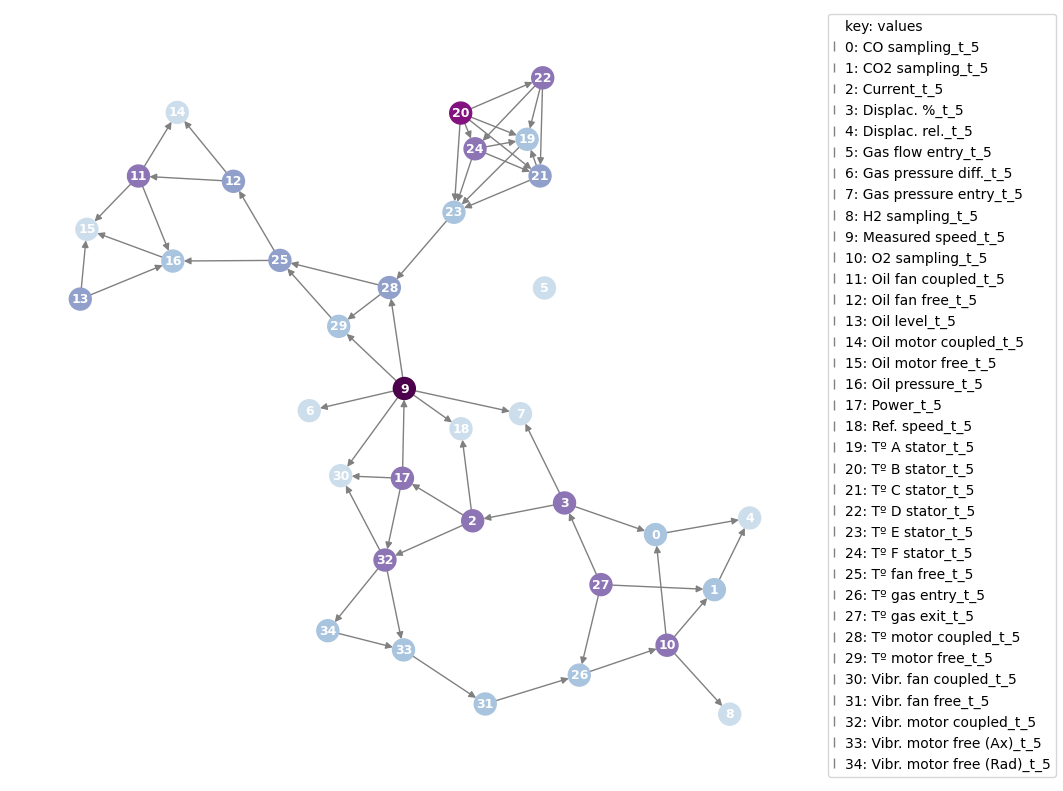

In [67]:
scores = dict(G.out_degree())


if static:
    fig1,axes=plt.subplots(1,1, figsize=(12,10))
    nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), node_color=list(scores.values()), vmin=-1.5,cmap=plt.cm.BuPu, with_labels=True, font_size=9, node_size=250, edge_color='gray', font_color='white', font_weight='heavy')
    fig1.legend(['key: values'] + [f'{k}: {reversed_enc_nodes_aux[k]}' for k, _ in scores.items()], markerscale=0, handlelength=0, loc='center right')
    plt.subplots_adjust(right=0.8)
    plt.savefig('otward_degree.svg', bbox_inches = 'tight')
    plt.show()


else:
    fig1,axes=plt.subplots(1,1, figsize=(35,12))
    norm = matplotlib.colors.Normalize(vmin=min(list(scores.values())), vmax=max(list(scores.values())))
    colors = plt.cm.BuPu(norm(list(scores.values())))
    ci_colors = {reversed_enc_nodes_aux[u]:v for u,v in zip(list(scores.keys()), colors)}
    plot_dynamic_network(G_names, offset=10, colors=ci_colors)

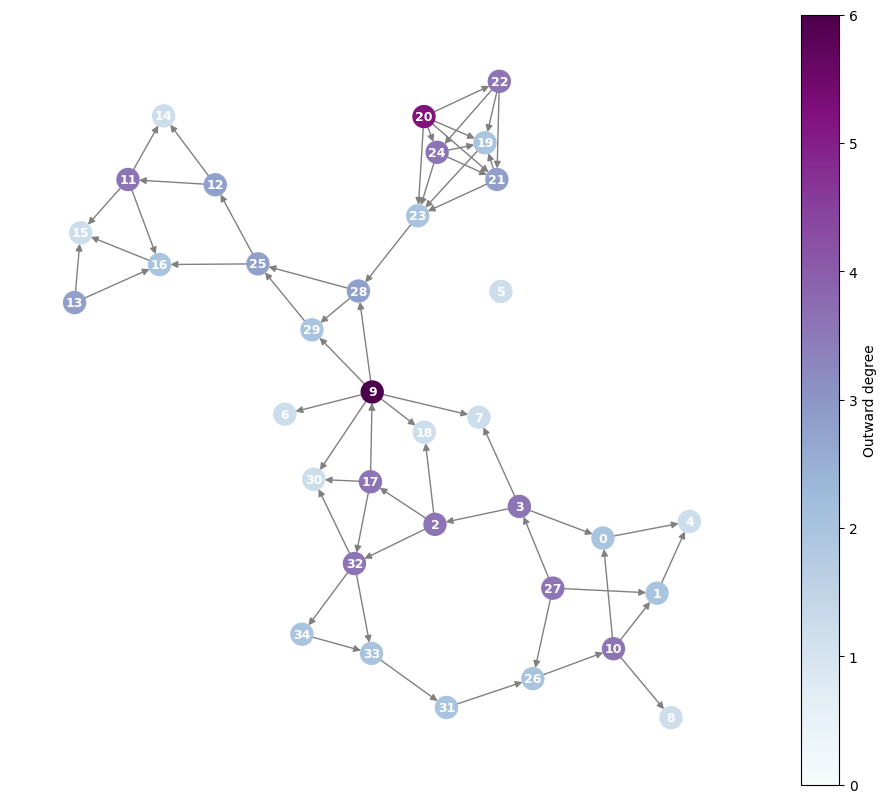

In [68]:
scores = dict(G.out_degree())

if static:
    fig1,axes=plt.subplots(1,1, figsize=(12,10))
    nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), node_color=list(scores.values()), vmin=-1.5,cmap=plt.cm.BuPu, with_labels=True, font_size=9, node_size=250, edge_color='gray', font_color='white', font_weight='heavy', ax=axes)
    # fig1.legend(['key: values'] + [f'{k}: {reversed_enc_nodes_aux[k]}' for k, _ in scores.items()], markerscale=0, handlelength=0, loc='center right')
    # plt.subplots_adjust(right=0.87)
    # Normalize node color values to be between 0 and 1 for colormap
    max_score = max(scores.values())
    min_score = min(scores.values())
    norm_scores = {node: (score - min_score) / (max_score - min_score) for node, score in scores.items()}

    # Convert normalized scores to RGBA tuples using colormap
    cmap = plt.cm.BuPu



    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_score, vmax=max_score))
    sm.set_array([])
    plt.colorbar(sm, label='Outward degree', ax=axes)
    plt.savefig('figures/outward_degree.svg', bbox_inches = 'tight')
    plt.show()


else:
    fig1,axes=plt.subplots(1,1, figsize=(35,12))
    norm = matplotlib.colors.Normalize(vmin=min(list(scores.values())), vmax=max(list(scores.values())))
    colors = plt.cm.BuPu(norm(list(scores.values())))
    ci_colors = {reversed_enc_nodes_aux[u]:v for u,v in zip(list(scores.keys()), colors)}
    plot_dynamic_network(G_names, offset=10, colors=ci_colors)

### Closeness

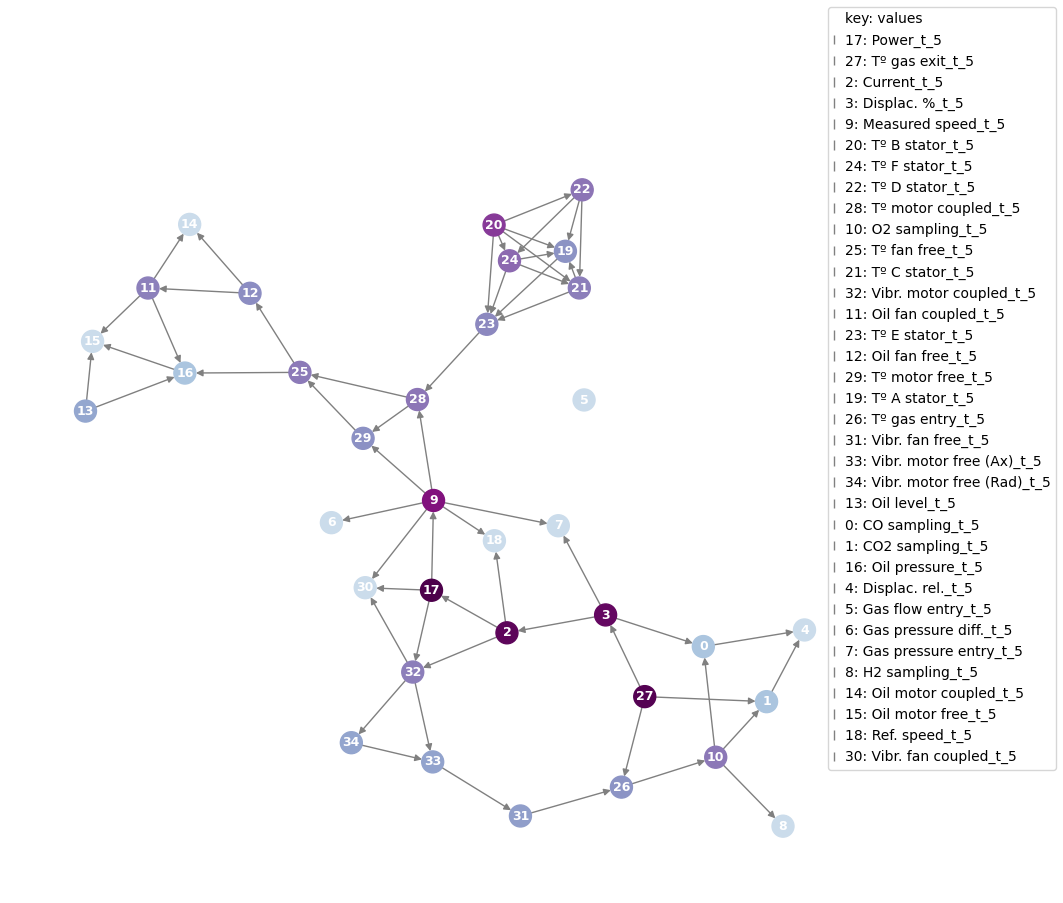

In [69]:
scores = nx.closeness_centrality(G.reverse())

if static:
    fig1,axes=plt.subplots(1,1, figsize=(12,10))
    nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), node_color=list(scores.values()), vmin=-0.05,cmap=plt.cm.BuPu, with_labels=True, font_size=9, node_size=250, edge_color='gray', font_color='white', font_weight='heavy')
    fig1.legend(['key: values'] + [f'{k}: {reversed_enc_nodes_aux[k]}' for k, _ in sorted(scores.items(), key=lambda item: -item[1])], markerscale=0, handlelength=0, loc='upper right')
    plt.subplots_adjust(right=0.85)
    plt.show()

else:
    fig1,axes=plt.subplots(1,1, figsize=(35,12))
    norm = matplotlib.colors.Normalize(vmin=min(list(scores.values())), vmax=max(list(scores.values())))
    colors = plt.cm.BuPu(norm(list(scores.values())))
    ci_colors = {reversed_enc_nodes_aux[u]:v for u,v in zip(list(scores.keys()), colors)}
    plot_dynamic_network(G_names, offset=10, colors=ci_colors)

### Betweenness

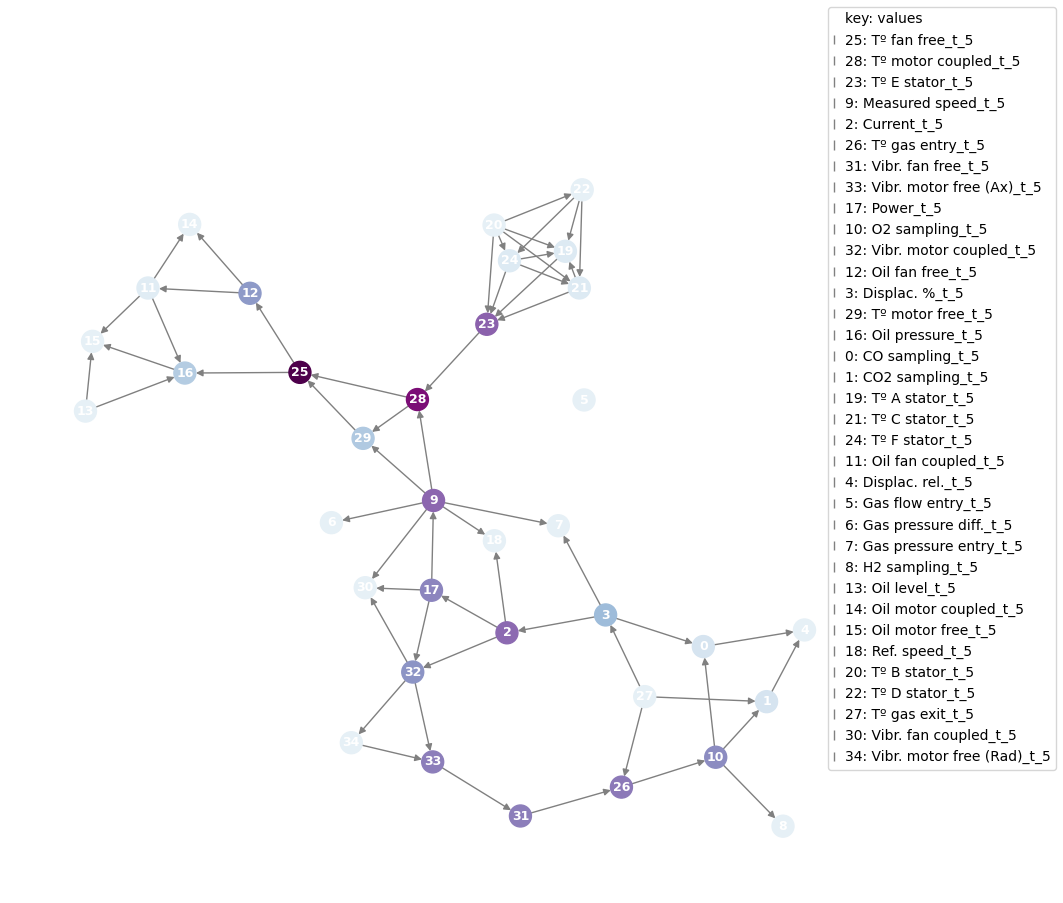

In [70]:
scores = nx.betweenness_centrality(G, normalized=False)

if static:
    fig1,axes=plt.subplots(1,1, figsize=(12,10))
    nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), node_color=list(scores.values()), vmin=-7,cmap=plt.cm.BuPu, with_labels=True, font_size=9, node_size=250, edge_color='gray', font_color='white', font_weight='heavy')
    fig1.legend(['key: values'] + [f'{k}: {reversed_enc_nodes_aux[k]}' for k, _ in sorted(scores.items(), key=lambda item: -item[1])], markerscale=0, handlelength=0, loc='upper right')
    plt.subplots_adjust(right=0.85)
    plt.show()

else:
    fig1,axes=plt.subplots(1,1, figsize=(35,12))
    norm = matplotlib.colors.Normalize(vmin=min(list(scores.values())), vmax=max(list(scores.values())))
    colors = plt.cm.BuPu(norm(list(scores.values())))
    ci_colors = {reversed_enc_nodes_aux[u]:v for u,v in zip(list(scores.keys()), colors)}
    plot_dynamic_network(G_names, offset=10, colors=ci_colors)

### Reverse PageRank

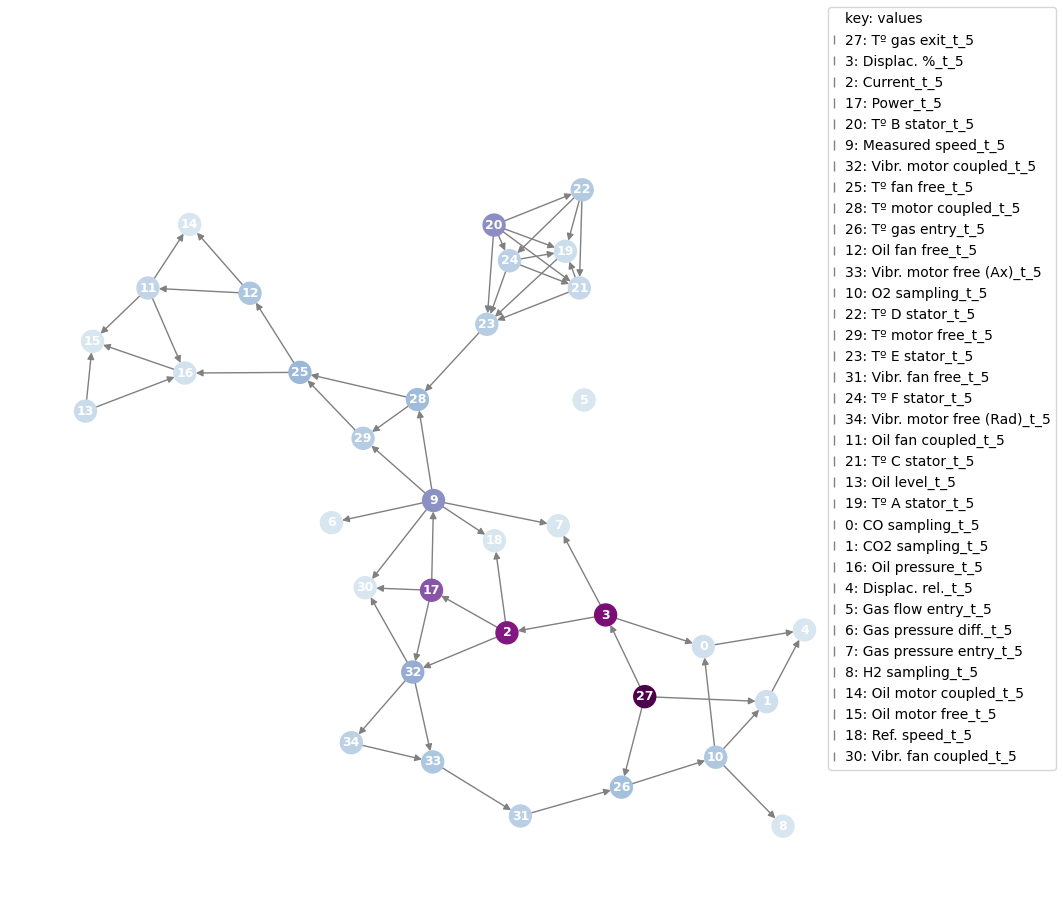

In [71]:
scores = nx.pagerank(G.reverse())

if static:
    fig1,axes=plt.subplots(1,1, figsize=(12,10))
    nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), node_color=list(scores.values()), vmin=-0.01,cmap=plt.cm.BuPu, with_labels=True, font_size=9, node_size=250, edge_color='gray', font_color='white', font_weight='heavy')
    fig1.legend(['key: values'] + [f'{k}: {reversed_enc_nodes_aux[k]}' for k, _ in sorted(scores.items(), key=lambda item: -item[1])], markerscale=0, handlelength=0, loc='upper right')
    plt.subplots_adjust(right=0.85)
    plt.show()

else:
    fig1,axes=plt.subplots(1,1, figsize=(35,12))
    norm = matplotlib.colors.Normalize(vmin=min(list(scores.values())), vmax=max(list(scores.values())))
    colors = plt.cm.BuPu(norm(list(scores.values())))
    ci_colors = {reversed_enc_nodes_aux[u]:v for u,v in zip(list(scores.keys()), colors)}
    plot_dynamic_network(G_names, offset=10, colors=ci_colors)

### Louvain

In [72]:
communities = nx.community.louvain_communities(G, resolution=1.3)
# with open('communities', 'rb') as f:
#     communities = pickle.load(f)
# communities

In [73]:
# with open('communities', 'wb') as f:
#     pickle.dump(communities, f)

In [74]:
def assign_sets_index(list_of_sets, elements):
    indexes = dict()
    for element in elements:
        found = False
        for i, s in enumerate(list_of_sets):
            if element in s:
                indexes[reversed_enc_nodes_aux[element]] = i
                found = True
                break
        if not found:
            indexes[reversed_enc_nodes_aux[element]] = None  # Element doesn't belong to any set
    return indexes


In [75]:
ci = assign_sets_index(communities, enc_nodes_aux.values())

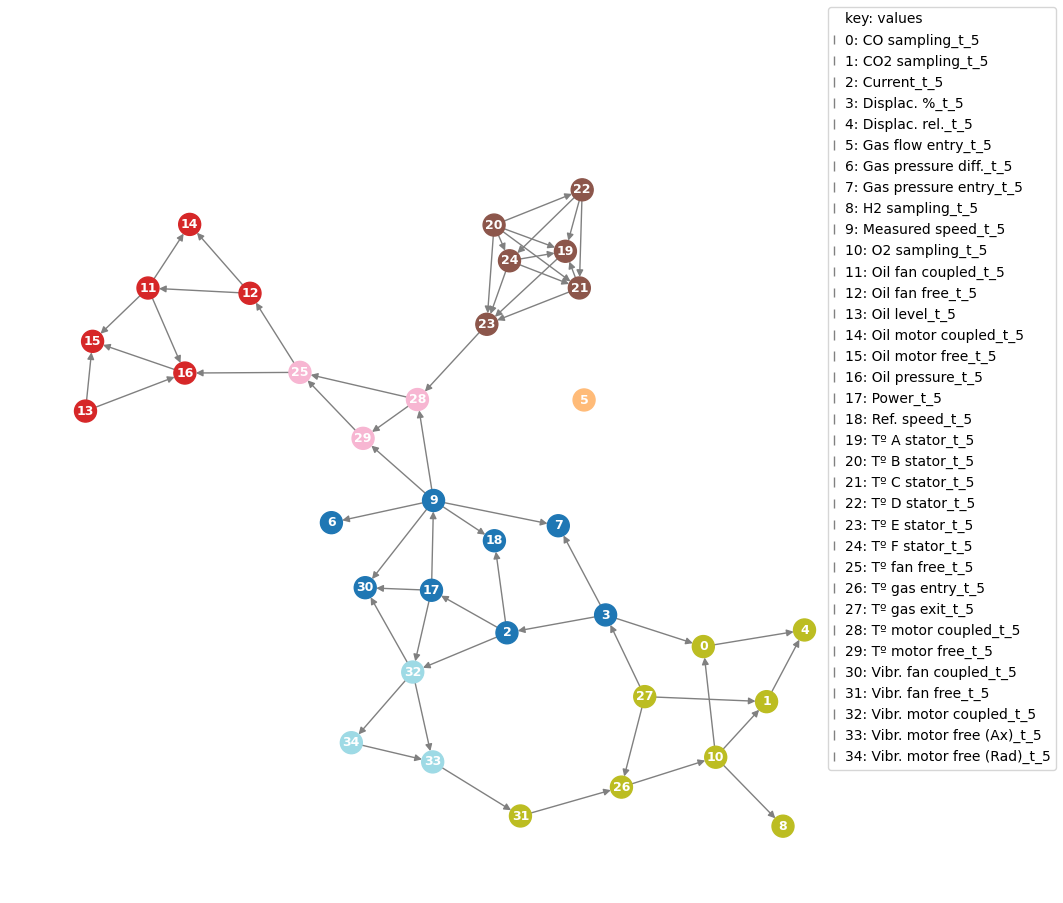

In [76]:
if static:
    fig1,axes=plt.subplots(1,1, figsize=(12,10))
    nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), node_color=[x for x in ci.values()],cmap=plt.cm.tab20, with_labels=True, font_size=9, node_size=250, edge_color='gray', font_color='white', font_weight='heavy')
    fig1.legend(['key: values'] + [f'{k}: {reversed_enc_nodes_aux[k]}' for k in G.nodes()], markerscale=0, handlelength=0, loc='upper right')
    plt.subplots_adjust(right=0.85)

    plt.show()
else:
    fig1,axes=plt.subplots(1,1, figsize=(35,12))
    colors = plt.cm.tab20([x for x in ci.values()])
    ci_colors = {u:v for u,v in zip(ci.keys(), colors)}
    plot_dynamic_network(G_names, offset=10, colors=ci_colors)

### Expert clusters


/tmp/ipykernel_133603/837484626.py:7: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('red')
/tmp/ipykernel_133603/837484626.py:8: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color('forestgreen')
/tmp/ipykernel_133603/837484626.py:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color('lightgreen')
/tmp/ipykernel_133603/837484626.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[4].set_color('lightseagreen')
/t

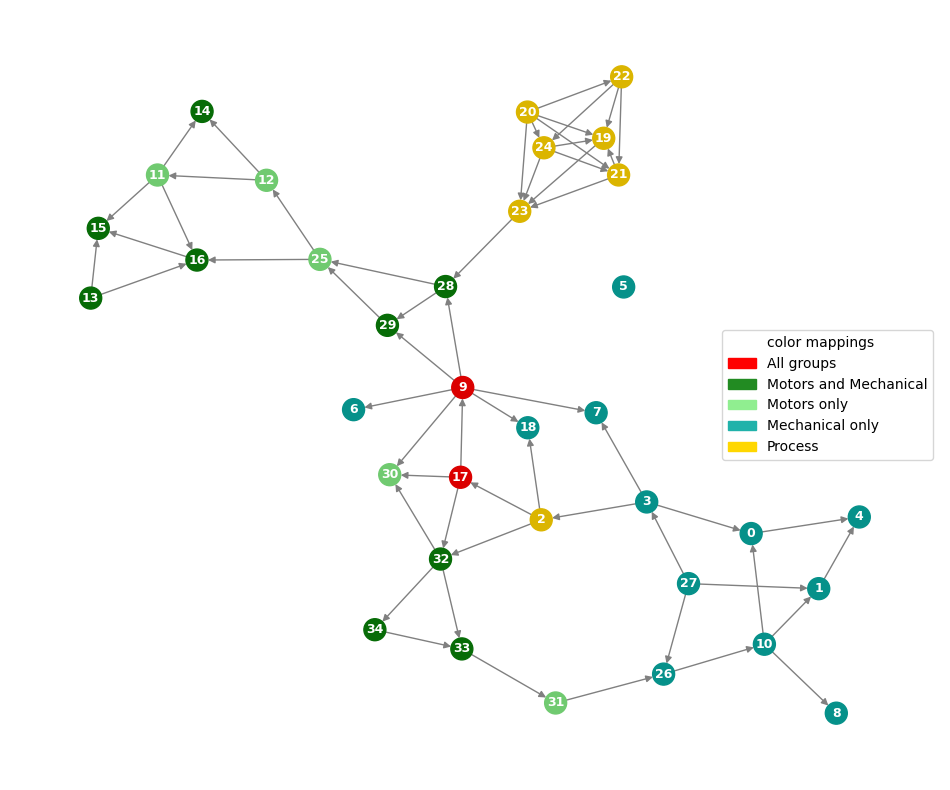

In [77]:
if static:    
    fig1,axes=plt.subplots(1,1, figsize=(12,10))
    colors = [groups['discrete_features']['multi_group'][groups['nodes'][node]['discrete_features']['multi_group'][0]]['color'] for node in nodes_aux]
    nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), node_color=colors, with_labels=True, font_size=9, node_size=250, edge_color='gray', font_color='white', font_weight='heavy', ax=axes)
    # fig1.legend(['key: values'] + [f'{k}: {reversed_enc_nodes_aux[k]}' for k in G.nodes()], markerscale=0, handlelength=0, loc='upper right')
    leg = axes.legend(['color mappings'] + ['All groups', 'Motors and Mechanical', 'Motors only', 'Mechanical only', 'Process'], markerscale=0, loc='center right')
    leg.legendHandles[1].set_color('red')
    leg.legendHandles[2].set_color('forestgreen')
    leg.legendHandles[3].set_color('lightgreen')
    leg.legendHandles[4].set_color('lightseagreen')
    leg.legendHandles[5].set_color('gold')
    # plt.subplots_adjust(right=1)
    plt.savefig('figures/expert_groups_static.svg', bbox_inches = 'tight')

    plt.show()
if not static:
    expert_colors = {'All groups':matplotlib.colors.to_rgba('#db0000'), 'Motors and Mechanical':matplotlib.colors.to_rgba('#076c07'), 'Motors only':matplotlib.colors.to_rgba('#dbb500'), 'Mechanical only':matplotlib.colors.to_rgba('#70ca70'), 'Process':matplotlib.colors.to_rgba('#06918a')}
    ci_colors = dict()
    for node in nodes_aux:
        ci_colors[node] = expert_colors[groups['nodes'][node]['discrete_features']['multi_group'][0]]
    fig1,axes=plt.subplots(1,1, figsize=(35,12))
    plot_dynamic_network(G_names, offset=10, colors=ci_colors)


### Hierarchical

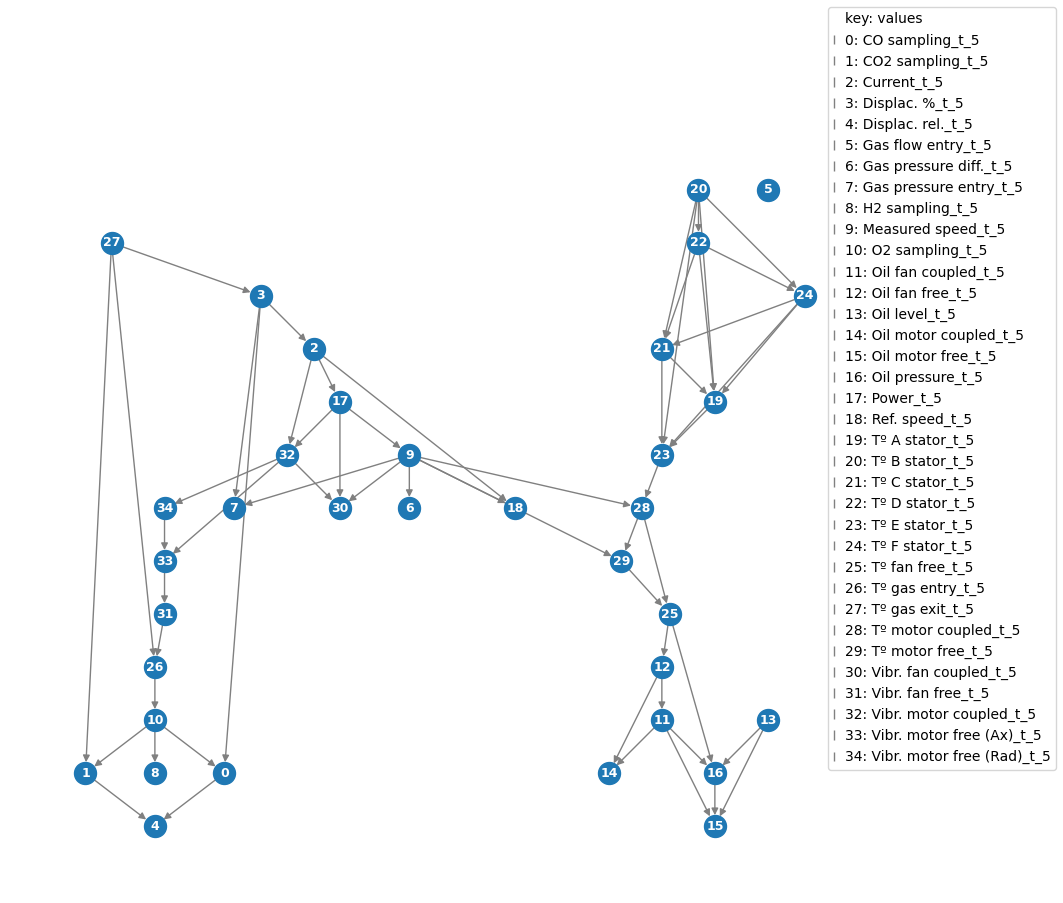

In [78]:
if static:
    fig1,axes=plt.subplots(1,1, figsize=(12,10))
    pos=graphviz_layout(G, prog='dot')
    nx.draw(G, pos, with_labels=True, font_size=9, node_size=250, edge_color='gray', font_color='white', font_weight='heavy')
    if static:
        fig1.legend(['key: values'] + [f'{v}: {k}' for k, v in enc_nodes_aux.items()], markerscale=0, handlelength=0, loc='upper right')
    plt.subplots_adjust(right=0.85)

    plt.show()

### Arc strength bnlearn

In [79]:
r(f'''
library(reticulate)
use_condaenv("tfm")
source_python("./dataframe_folder.py")
n_cycles <- {n_cycles}
dt_train <- get_train_df(n_cycles)
size <- 6
f_dt_train <- fold_dataframe(size, n_cycles)
strengths <- arc.strength(net, f_dt_train, 'bic-g')
''')

In [80]:
with (robj.default_converter + pandas2ri.converter).context():
    strengths = robj.conversion.get_conversion().rpy2py(robj.globalenv['strengths'])
strengths

,from,to,strength
1,Current_t_0,Power_t_0,-36345.860155
2,Vibr. motor coupled_t_0,Vibr. motor free (Rad)_t_0,-31883.461618
3,Tº motor coupled_t_0,Tº motor free_t_0,-21915.045948
4,Vibr. motor free (Rad)_t_0,Vibr. motor free (Ax)_t_0,-7914.648650
5,Power_t_0,Vibr. motor coupled_t_0,-6740.602986
...,...,...,...
529,Oil level_t_3,Oil level_t_0,-91.897104
530,H2 sampling_t_1,H2 sampling_t_0,-151.444903
531,H2 sampling_t_5,H2 sampling_t_4,-139.915256
532,Oil level_t_4,Oil level_t_1,-111.619944


In [81]:
if static:
    neurosuites_df = pd.read_csv(f'./nets/{fan}/exported/DGBN_ady_matrix_static.csv', index_col=0)
else:
    neurosuites_df = pd.read_csv(f'./nets/{fan}/exported/DGBN_ady_matrix.csv', index_col=0)
for i in range(len(neurosuites_df)):
    for j in range(len(neurosuites_df)):
        if neurosuites_df.iloc[i,j]==1:
            neurosuites_df.iloc[i,j] = -strengths[(strengths['from'] == neurosuites_df.columns[i]) & (strengths['to'] == neurosuites_df.columns[j])]['strength']
if static:
    neurosuites_df.to_csv(f'./nets/{fan}/exported/DGBN_ady_matrix_influence_bnlearn_static.csv')
else:
    neurosuites_df.to_csv(f'./nets/{fan}/exported/DGBN_ady_matrix_influence_bnlearn.csv')

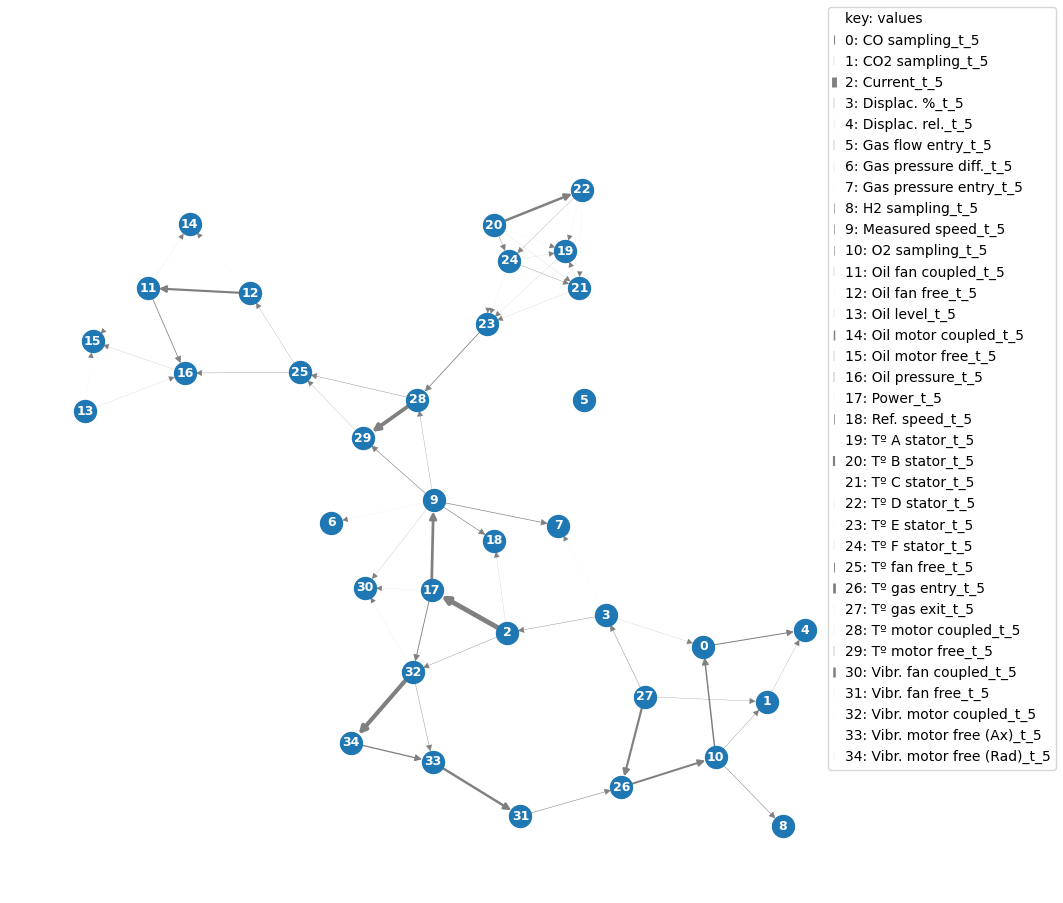

In [82]:
scaler = MinMaxScaler()
strengths_plot = [-strengths[(strengths['from'] == reversed_enc_nodes_aux[u]) & (strengths['to'] == reversed_enc_nodes_aux[v])]['strength'] for u,v in G.edges()]
if static:
    fig1,axes=plt.subplots(1,1, figsize=(12,10))
    nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), with_labels=True, font_size=9, node_size=250, edge_color='gray', font_color='white', font_weight='heavy', width=3.5*scaler.fit_transform(strengths_plot))
    fig1.legend(['key: values'] + [f'{k}: {reversed_enc_nodes_aux[k]}' for k in G.nodes()], markerscale=0, handlelength=0, loc='upper right')
    plt.subplots_adjust(right=0.85)
    plt.savefig('figures/bnlearn_arc_strength.svg')
    plt.show()
else:
    fig1,axes=plt.subplots(1,1, figsize=(35,12))
    colors = plt.cm.tab20([x for x in ci.values()])
    ci_colors = {u:v for u,v in zip(ci.keys(), colors)}
    plot_dynamic_network(G_names, offset=10, strengths=5*scaler.fit_transform(strengths_plot))

# Parametric analysis

In [83]:
for node in [n for n in G.nodes()][:]:
    with pm.Model() as model:
        parents_deps = list()
        nodename = reversed_enc_nodes_aux[node]
        print(nodename)
        if len(dbn_parameters[nodename]['parents_names'])>0:
            for i, parent in enumerate(dbn_parameters[nodename]['parents_names']):
                x = pm.Normal(parent, mu=dbn_parameters[parent]['mean'], sigma=dbn_parameters[parent]['variance'])
                β = dbn_parameters[nodename]['parents_coeffs'][i]
                parents_deps.append(β*(x-dbn_parameters[parent]['mean']))

            child = pm.Normal(nodename, mu=dbn_parameters[nodename]['mean'] + reduce(lambda x, y: x+y, parents_deps), sigma=dbn_parameters[nodename]['variance'])

            samples = pm.sample(1000, cores=10, progressbar=False, init="adapt_diag")
            samples = pd.DataFrame.from_dict(np.array(samples).tolist())
            samples.to_csv(f'./samplings/{fan}/{nodename}.csv', index=False)
    

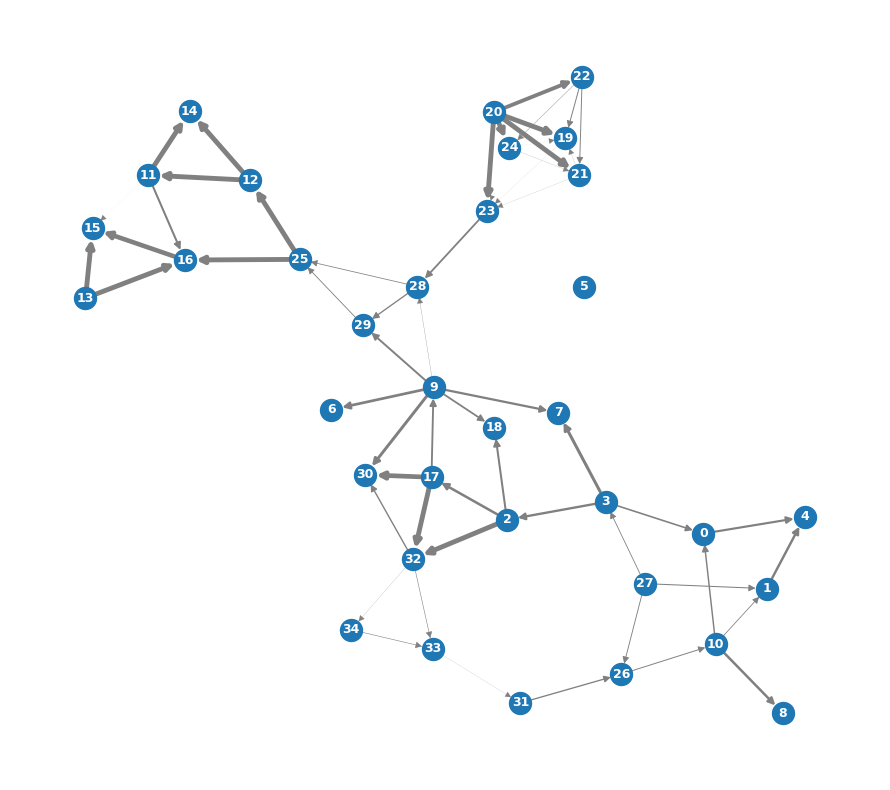

In [84]:
def kl_divergence(mu1, sigma1, mu2, sigma2):
    term = (sigma1**2 + (mu1 - mu2)**2)/(2*sigma2**2)
    return np.log(sigma2/sigma1) + term + 0.5
jdivergence = lambda mu1, sigma1, mu2, sigma2: (kl_divergence(mu1, sigma1, mu2, sigma2) + kl_divergence(mu1, sigma1, mu2, sigma2))/2
jdivergence_norm = lambda mu1, sigma1, mu2, sigma2: jdivergence(mu1, sigma1, mu2, sigma2)/np.sqrt(jdivergence(mu1, sigma1, mu2, sigma2)**2+200)

if static:
    neurosuites_df = pd.read_csv(f'./nets/{fan}/exported/DGBN_ady_matrix_static.csv', index_col=0)
else:
    neurosuites_df = pd.read_csv(f'./nets/{fan}/exported/DGBN_ady_matrix.csv', index_col=0)
for i in range(len(neurosuites_df)):
    for j in range(len(neurosuites_df)):
        if neurosuites_df.iloc[i,j]==1:
            origin = neurosuites_df.columns[i]
            dest = neurosuites_df.columns[j]
            samples = pd.read_csv(f'./samplings/{fan}/{dest}.csv')

            neurosuites_df.iloc[i,j] = 2*jdivergence_norm(dbn_parameters[origin]['mean'], np.sqrt(dbn_parameters[origin]['variance']), samples[dest].mean(), samples[dest].std())
if static:
    neurosuites_df.to_csv(f'./nets/{fan}/exported/DGBN_ady_matrix_influence_jdivergence_static.csv')
else:
    neurosuites_df.to_csv(f'./nets/{fan}/exported/DGBN_ady_matrix_influence_jdivergence.csv')


scaler = MinMaxScaler()
strengths_plot = [neurosuites_df.iloc[np.where(neurosuites_df.columns == reversed_enc_nodes_aux[u])[0], np.where(neurosuites_df.columns == reversed_enc_nodes_aux[v])[0]].values[0] for u,v in G.edges()]
if static:
    fig1,axes=plt.subplots(1,1, figsize=(12,10))
    nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), with_labels=True, font_size=9, node_size=250, edge_color='gray', font_color='white', font_weight='heavy', width=3.5*scaler.fit_transform(np.array(strengths_plot).reshape(-1, 1)), ax=axes)
    # fig1.legend(['key: values'] + [f'{k}: {reversed_enc_nodes_aux[k]}' for k in G.nodes()], markerscale=0, handlelength=0, loc='upper right')
    plt.subplots_adjust(right=0.85)
    plt.savefig('figures/j_divergence_static.svg', bbox_inches = 'tight')
    plt.show()
else:
    fig1,axes=plt.subplots(1,1, figsize=(35,12))
    colors = plt.cm.tab20([x for x in ci.values()])
    ci_colors = {u:v for u,v in zip(ci.keys(), colors)}
    plot_dynamic_network(G_names, offset=10, strengths=np.array(strengths_plot))